In [25]:
import numpy as np
import matplotlib.pyplot as plt
from gurobipy import Model, GRB, quicksum
from concurrent.futures import ProcessPoolExecutor
import concurrent.futures
import time

from ParallelSolve import gurobi_network_first_stage, majority_vote_network

In [26]:
rng = np.random.default_rng(seed = 2024)
def sample_func(rng, distribution_name, **dist_params):
     if hasattr(rng, distribution_name):
        dist_func = getattr(rng, distribution_name)
        samples = dist_func(**dist_params)
        return samples + 1 if distribution_name == "pareto" else samples
     else:
        raise ValueError(f"Unsupported distribution: {distribution_name}")

In [27]:
def gurobi_second_stage(sample_S, sample_D, C, Q_sp, Q_pc, R, M, H, x):
    # second stage LP problem
    s, p, g = Q_sp.shape
    c, g, k = sample_D.shape
    model = Model("second_stage")
    model.setParam(GRB.Param.OutputFlag, 0)
    y_sp = model.addVars(s, p, g, k, lb=0, vtype=GRB.CONTINUOUS, name="y_sp")
    y_pc = model.addVars(p, c, g, k, lb=0, vtype=GRB.CONTINUOUS, name="y_pc")
    z = model.addVars(c, g, k, lb=0, vtype=GRB.CONTINUOUS, name="z")

    obj_expr = 1/k * quicksum(Q_sp[i, j, l] * y_sp[i, j, l, a] for i in range(s) for j in range(p) for l in range(g) for a in range(k))\
                        + 1/k * quicksum(Q_pc[j, i, l] * y_pc[j, i, l, a] for j in range(p) for i in range(c) for l in range(g) for a in range(k))\
                            + 1/k * quicksum(H[i, l] * z[i, l, a] for i in range(c) for l in range(g) for a in range(k))
    
    model.setObjective(obj_expr, GRB.MINIMIZE)

    model.addConstrs((quicksum(y_sp[i, j, l, a] for i in range(s)) - quicksum(y_pc[j, i, l, a] for i in range(c)) == 0
                        for a in range(k) for l in range(g) for j in range(p)), name="flow")
    
    model.addConstrs((quicksum(y_pc[j, i, l, a] + z[i, l, a] for j in range(p)) >= sample_D[i, l, a]
                        for a in range(k) for l in range(g) for i in range(c)), name="demand")
    
    model.addConstrs((quicksum(y_sp[i, j, l, a] for j in range(p)) <= sample_S[i, l, a]
                        for a in range(k) for l in range(g) for i in range(s)), name="supply")
    
    model.addConstrs((quicksum(R[j, l] * quicksum(y_sp[i, j, l, a] for i in range(s)) for l in range(g)) <= M[j] * x[j]
                        for a in range(k) for j in range(p)), name="capacity")
    
    model.optimize()

    if model.status == GRB.OPTIMAL:
        return model.ObjVal + sum(C[j] * x[j] for j in range(p)) 
    else:
        print("No optimal solution found.")
        return None
    

In [28]:
def comparison(parameters,a_ls,B,number_of_iterations,ratio,sample_number, rng):
    C, Q_sp, Q_pc, R, M, H = parameters['C'], parameters['Q_sp'], parameters['Q_pc'], parameters['R'], parameters['M'], parameters['H']
    a_S, a_D = a_ls[0], a_ls[1]

    SAA_list = []
    majority_list = []
    for n in sample_number:
        SAA_intermediate = []
        majority_intermediate = []
        for _ in range(number_of_iterations):
            sample_S = sample_func(rng, 'pareto', size=(s,g,n), a=a_S)
            sample_D = sample_func(rng, 'pareto', size=(c,g,n), a=a_D)

            SAA = majority_vote_network(sample_S,sample_D, 1, n, gurobi_network_first_stage, rng, C, Q_sp, Q_pc, R, M, H)
            SAA_intermediate.append(tuple([round(x) for x in SAA]))

            majority = majority_vote_network(sample_S, sample_D, B, int(n*ratio), gurobi_network_first_stage, rng, C, Q_sp, Q_pc, R, M, H)
            majority_intermediate.append(tuple([round(x) for x in majority]))
            
        SAA_list.append(SAA_intermediate)
        majority_list.append(majority_intermediate)
    
    return SAA_list, majority_list

def evaluation_CI(SAA_list, majority_list, parameters, a_ls, number_of_iterations, sample_number, large_number_sample, rng):
    C, Q_sp, Q_pc, R, M, H = parameters['C'], parameters['Q_sp'], parameters['Q_pc'], parameters['R'], parameters['M'], parameters['H']
    a_S, a_D = a_ls[0], a_ls[1]
    
    def unique_solutions(lists):
        unique_sols = []
        for sublist in lists:
            for item in sublist:
                if item not in unique_sols:
                    unique_sols.append(item)
        return unique_sols
    
    all_solutions = unique_solutions(SAA_list + majority_list)
    solution_obj_values = {str(solution): 0 for solution in all_solutions}

    for solution in all_solutions:
        large_sample_S = sample_func(rng, 'pareto', size=(s,g,large_number_sample), a=a_S)  
        large_sample_D = sample_func(rng, 'pareto', size=(c,g,large_number_sample), a=a_D)
        obj_value = gurobi_second_stage(large_sample_S, large_sample_D, C, Q_sp, Q_pc, R, M, H, solution)
        solution_obj_values[str(solution)] = obj_value
    
    SAA_obj_lists, majority_obj_lists, SAA_obj_list, majority_obj_list = [], [], [], []
    for i in range(len(sample_number)):
        current_SAA_obj_list = []
        current_majority_obj_list = []
        for j in range(number_of_iterations):
            SAA_obj = solution_obj_values[str(SAA_list[i][j])]
            majority_obj = solution_obj_values[str(majority_list[i][j])]
            current_SAA_obj_list.append(SAA_obj)
            current_majority_obj_list.append(majority_obj)
        
        SAA_obj_lists.append(current_SAA_obj_list)
        majority_obj_lists.append(current_majority_obj_list)
        SAA_obj_list.append(np.mean(current_SAA_obj_list))
        majority_obj_list.append(np.mean(current_majority_obj_list))

    return SAA_obj_lists, majority_obj_lists, SAA_obj_list, majority_obj_list

# def evaluate_solution(solution, parameters, a_ls, large_number_sample, rng):
#     C, Q_sp, Q_pc, R, M, H = parameters['C'], parameters['Q_sp'], parameters['Q_pc'], parameters['R'], parameters['M'], parameters['H']
#     a_S, a_D = a_ls[0], a_ls[1]
    
#     # Assuming sample_func and gurobi_second_stage are defined elsewhere and accessible here
#     large_sample_S = sample_func(rng, 'pareto', size=(s, g, large_number_sample), a=a_S)  
#     large_sample_D = sample_func(rng, 'pareto', size=(c, g, large_number_sample), a=a_D)
#     obj_value = gurobi_second_stage(large_sample_S, large_sample_D, C, Q_sp, Q_pc, R, M, H, solution)
#     return str(solution), obj_value

# def evaluation_CI(SAA_list, majority_list, parameters, a_ls, number_of_iterations, sample_number, large_number_sample, rng):
#     C, Q_sp, Q_pc, R, M, H = parameters['C'], parameters['Q_sp'], parameters['Q_pc'], parameters['R'], parameters['M'], parameters['H']
#     a_S, a_D = a_ls[0], a_ls[1]

#     def unique_solutions(lists):
#         unique_sols = []
#         for sublist in lists:
#             for item in sublist:
#                 if item not in unique_sols:
#                     unique_sols.append(item)
#         return unique_sols

#     all_solutions = unique_solutions(SAA_list + majority_list)
    
#     solution_obj_values = {}
#     num_processors = 9
#     with ProcessPoolExecutor(max_workers=num_processors) as executor:
#         # Create a list or generator of tasks with all necessary arguments for evaluate_solution
#         tasks = (executor.submit(evaluate_solution, solution, parameters, a_ls, large_number_sample, rng) for solution in all_solutions)
        
#         for future in concurrent.futures.as_completed(tasks):
#             solution, obj_value = future.result()
#             solution_obj_values[solution] = obj_value

#     SAA_obj_lists, majority_obj_lists, SAA_obj_list, majority_obj_list = [], [], [], []
#     for i in range(len(sample_number)):
#         current_SAA_obj_list = []
#         current_majority_obj_list = []
#         for j in range(number_of_iterations):
#             SAA_obj = solution_obj_values[str(SAA_list[i][j])]
#             majority_obj = solution_obj_values[str(majority_list[i][j])]
#             current_SAA_obj_list.append(SAA_obj)
#             current_majority_obj_list.append(majority_obj)
        
#         SAA_obj_lists.append(current_SAA_obj_list)
#         majority_obj_lists.append(current_majority_obj_list)
#         SAA_obj_list.append(np.mean(current_SAA_obj_list))
#         majority_obj_list.append(np.mean(current_majority_obj_list))

#     return SAA_obj_lists, majority_obj_lists, SAA_obj_list, majority_obj_list



def figure_plot(SAA_obj_list, majority_obj_list,sample_number):
    # plot the objective values of SAA and Bagging-SAA
    _, ax = plt.subplots()
    ax.plot(sample_number, SAA_obj_list, marker = 'o', markeredgecolor = 'none', color = 'blue',linestyle = 'solid', linewidth = 2, label = 'SAA')
    ax.plot(sample_number, majority_obj_list, marker = 's', markeredgecolor = 'none', color = 'red',linestyle = 'solid', linewidth = 2, label = 'Majority Vote')
    ax.set_xlabel('Number of samples', size = 20)
    ax.set_ylabel('Objective', size = 20)
    ax.legend(loc = 'lower right')
    plt.show()
    return

In [29]:
# Run script with a single set of random parameters

s = 3 # number of suppliers
p = 2 # number of facilities
c = 3 # number of consumers
g = 5 # number of products

# Randomly generate input parameters based on the given dimensions
parameters = {
    'C': np.random.rand(p),           # Unit cost for building a facility
    'Q_sp': np.random.rand(s, p, g),  # Unit flow cost from supplier to facility
    'Q_pc': np.random.rand(p, c, g),  # Unit flow cost from facility to customer
    'R': np.random.rand(p, g),        # Unit processing requirement
    'M': np.random.rand(p),           # Processing capacity
    'H': np.random.rand(c, g)        # Multiplier
}

# Pareto distribution parameter for S and D, make sure the supply is larger than demand
a_ls = np.array([np.random.uniform(1.9,2), np.random.uniform(2,2.1)]) 

Set parameter Username
Academic license - for non-commercial use only - expires 2025-03-13
Set parameter Username
Academic license - for non-commercial use only - expires 2025-03-13
Set parameter Username
Academic license - for non-commercial use only - expires 2025-03-13
Set parameter Username
Academic license - for non-commercial use only - expires 2025-03-13
Set parameter Username
Academic license - for non-commercial use only - expires 2025-03-13
Set parameter Username
Academic license - for non-commercial use only - expires 2025-03-13
Set parameter Username
Academic license - for non-commercial use only - expires 2025-03-13
Set parameter Username
Set parameter Username
Academic license - for non-commercial use only - expires 2025-03-13
Academic license - for non-commercial use only - expires 2025-03-13
Set parameter Username
Academic license - for non-commercial use only - expires 2025-03-13
Set parameter Username
Academic license - for non-commercial use only - expires 2025-03-13

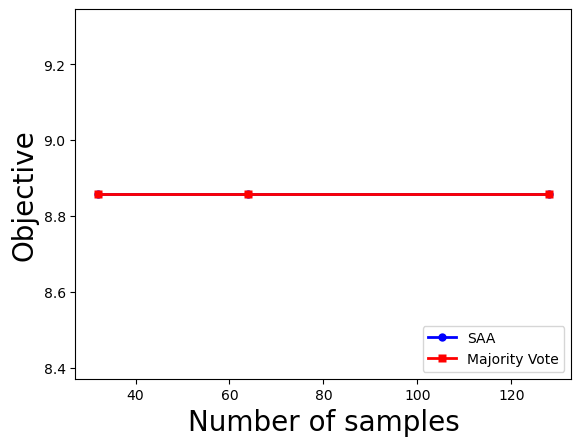

In [30]:
B = 5
number_of_iterations = 2
ratio = 0.1
sample_number = np.array([2**i for i in range(5, 8)])
large_number_sample = 2000

SAA_list, majority_list = comparison(parameters,a_ls,B,number_of_iterations,ratio,sample_number, rng)
SAA_obj_lists, majority_obj_lists, SAA_obj_list, majority_obj_list = evaluation_CI(SAA_list, majority_list, parameters, a_ls, number_of_iterations, sample_number, large_number_sample, rng)
figure_plot(SAA_obj_list, majority_obj_list, sample_number)

In [33]:
# repeated experiments
s = np.random.randint(2, 4) # number of suppliers
p = np.random.randint(2, 4) # number of facilities
c = np.random.randint(2, 4) # number of consumers
g = np.random.randint(2, 6) # number of products

B = 100
number_of_iterations = 5
ratio = 0.1
sample_number = np.array([2**i for i in range(6, 14)])
large_number_sample = 200000

results_list = []
for _ in range(20):
    print(f"Experiment {_}")
    tic = time.time()
    # TODO: May need to adjust the range of random number generation/ fix some parameters
    parameters = {
        'C': 5*np.random.rand(p),           # Unit cost for building a facility
        'Q_sp': 5*np.random.rand(s, p, g),  # Unit flow cost from supplier to facility
        'Q_pc': 5*np.random.rand(p, c, g),  # Unit flow cost from facility to customer
        'R': 5*np.random.rand(p, g),        # Unit processing requirement
        'M': 5*np.random.rand(p),           # Processing capacity
        'H': 5*np.random.rand(c, g)        # Multiplier
    }
    
    # Pareto distribution parameter for S and D, make sure the supply is larger than demand
    # TODO: May need to adjust the range of random sample generation
    a_ls = np.array([np.random.uniform(1.7,2), np.random.uniform(2,2.3)])
    
    SAA_list, majority_list = comparison(parameters,a_ls,B,number_of_iterations,ratio,sample_number, rng)
    SAA_obj_lists, majority_obj_lists, SAA_obj_list, majority_obj_list = evaluation_CI(SAA_list, majority_list, parameters, a_ls, number_of_iterations, sample_number, large_number_sample, rng)
    result_dict = {
        'parameters': parameters,
        'a_ls': a_ls,
        'SAA_obj_lists': SAA_obj_lists,
        'majority_obj_lists': majority_obj_lists,
        'SAA_obj_list': SAA_obj_list,
        'majority_obj_list': majority_obj_list
    }
    results_list.append(result_dict)
    toc = time.time()
    print(f"Experiment {_} completed in {toc - tic} seconds.")
    

Experiment 0
Set parameter Username
Academic license - for non-commercial use only - expires 2025-03-13
Set parameter Username
Academic license - for non-commercial use only - expires 2025-03-13
Set parameter Username
Set parameter Username
Academic license - for non-commercial use only - expires 2025-03-13
Set parameter Username
Set parameter Username
Academic license - for non-commercial use only - expires 2025-03-13
Set parameter Username
Set parameter Username
Academic license - for non-commercial use only - expires 2025-03-13
Academic license - for non-commercial use only - expires 2025-03-13
Set parameter Username
Academic license - for non-commercial use only - expires 2025-03-13
Academic license - for non-commercial use only - expires 2025-03-13
Set parameter Username
Academic license - for non-commercial use only - expires 2025-03-13
Academic license - for non-commercial use only - expires 2025-03-13
Set parameter Username
Academic license - for non-commercial use only - expir

Parameters: {'C': array([0.94654309, 3.33478564]), 'Q_sp': array([[[3.00207131, 2.4631915 , 4.76178683, 2.32517398],
        [2.09781667, 1.27196848, 3.43772402, 1.13762474]],

       [[4.08364089, 1.67262123, 3.45754736, 1.19734549],
        [4.64023346, 4.81262119, 2.42008241, 1.77999667]]]), 'Q_pc': array([[[0.83520268, 1.01973266, 0.37702084, 3.13576571],
        [0.2042338 , 0.31913298, 2.95491791, 4.94785187],
        [3.45379017, 1.69295663, 3.72237471, 4.06620059]],

       [[2.32386075, 0.18289694, 2.64638775, 0.48911838],
        [0.33856867, 2.74480955, 0.1484956 , 3.5628809 ],
        [0.96206799, 2.03048969, 3.42224893, 2.27694123]]]), 'R': array([[0.09477008, 2.27507372, 0.11315821, 4.44333297],
       [4.573426  , 2.15432904, 2.71312573, 2.96091971]]), 'M': array([1.29134476, 4.23433684]), 'H': array([[3.62204566, 4.82520921, 4.757144  , 0.52366894],
       [4.52447827, 3.11775027, 0.9261418 , 0.95649328],
       [1.64931229, 2.8818148 , 3.84496583, 4.7019026 ]])}, a_ls:

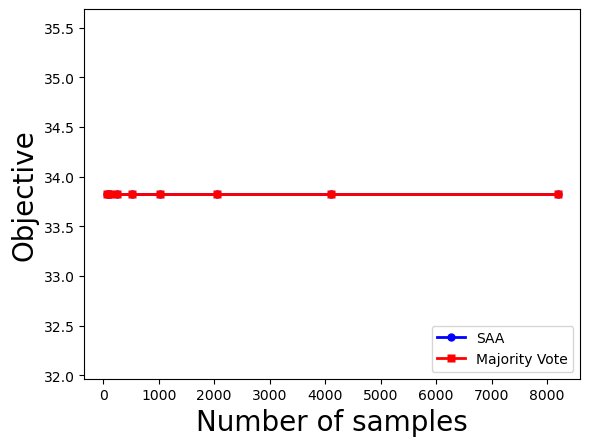

Parameters: {'C': array([1.68083206, 2.83083303]), 'Q_sp': array([[[2.90670361, 0.17297031, 0.31146316, 1.10127319],
        [2.51400524, 4.74696547, 1.32043914, 2.59368542]],

       [[2.63856445, 2.98118809, 1.9008693 , 0.05575462],
        [4.04148818, 1.16658648, 0.91003446, 2.23702366]]]), 'Q_pc': array([[[1.01295919, 3.80912581, 1.42327019, 2.70819924],
        [1.33868316, 2.55762241, 2.92341371, 2.54711465],
        [2.74882189, 3.596001  , 4.22228416, 3.38328817]],

       [[3.3467817 , 1.62817045, 0.12957607, 1.5001989 ],
        [4.28134829, 1.18441344, 2.38089339, 4.22722328],
        [2.35428371, 4.76047547, 0.03967044, 1.30558477]]]), 'R': array([[0.42733218, 2.57547028, 1.48884899, 4.30118556],
       [1.57028168, 1.55623914, 1.52010557, 2.96806602]]), 'M': array([1.54455096, 1.71209352]), 'H': array([[4.2719638 , 4.22255722, 0.2937346 , 0.63704468],
       [1.10713002, 4.51221897, 3.88574705, 2.55320854],
       [4.8178617 , 4.05469259, 1.68380358, 2.82189252]])}, a_ls:

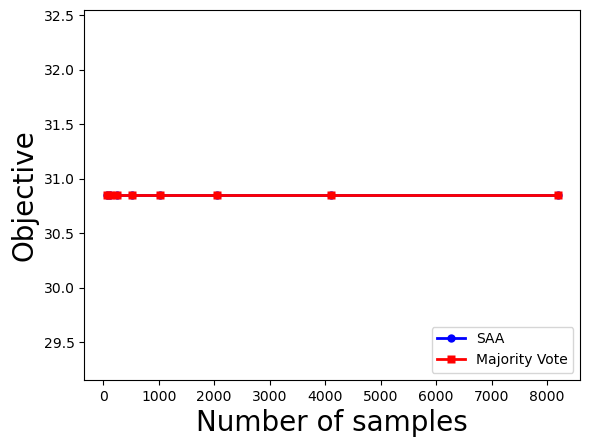

Parameters: {'C': array([1.32086885, 3.89142891]), 'Q_sp': array([[[1.02568639, 2.30542527, 1.72508807, 1.74313815],
        [3.82703496, 3.11018592, 2.61596544, 0.38473039]],

       [[0.96065892, 2.85586709, 3.86311447, 0.13269254],
        [2.87046086, 1.00395711, 1.06933908, 4.66514688]]]), 'Q_pc': array([[[2.92155349, 3.86450556, 0.44505508, 1.03638418],
        [3.25536671, 1.11667925, 4.61441064, 4.0525656 ],
        [2.94083254, 3.74720533, 2.81330572, 2.34592077]],

       [[0.19951946, 0.86163698, 2.94503797, 0.43254467],
        [4.63735057, 0.91342251, 2.04589205, 1.39952842],
        [2.18878864, 1.11833116, 3.92097322, 0.91113698]]]), 'R': array([[3.92584351, 1.11710943, 3.35612345, 4.701347  ],
       [1.30627381, 1.97983306, 3.96923929, 3.3635116 ]]), 'M': array([0.39591725, 1.144542  ]), 'H': array([[2.27868177, 2.09868238, 2.76357608, 1.55832408],
       [2.12371654, 4.81377219, 3.46604785, 1.31702322],
       [2.91196178, 0.22902709, 0.06077303, 2.94685667]])}, a_ls:

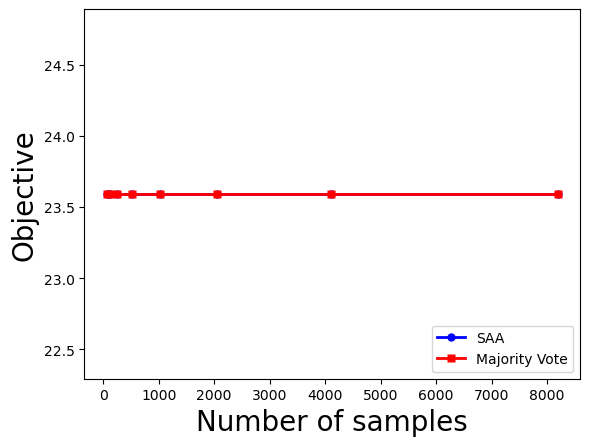

Parameters: {'C': array([3.05814084, 3.59765077]), 'Q_sp': array([[[1.35333259, 0.32731302, 3.98984078, 1.01600447],
        [2.46214232, 1.78510303, 1.81457052, 0.41629108]],

       [[3.83406137, 2.57027198, 4.83879611, 2.71857908],
        [4.63664135, 0.1196037 , 3.51381709, 3.48163419]]]), 'Q_pc': array([[[2.58457291, 3.3788512 , 1.9377262 , 0.85982527],
        [4.60937403, 3.70146675, 3.01269379, 3.05934184],
        [1.5556513 , 1.2173925 , 3.06693839, 1.69109134]],

       [[2.00036896, 4.09185279, 0.25529153, 1.88439043],
        [0.61312328, 3.35727289, 2.65433171, 0.89007927],
        [4.20632388, 3.86073477, 0.89515285, 4.11458627]]]), 'R': array([[3.18311138, 4.66602167, 3.97635176, 0.12475947],
       [4.63236104, 1.32061971, 4.87972134, 0.43394748]]), 'M': array([2.34514876, 3.05282731]), 'H': array([[4.87349885, 1.9314634 , 1.88528285, 4.85098541],
       [4.47355836, 2.56871016, 4.4349189 , 0.43407637],
       [3.75129213, 1.99664958, 0.40210699, 2.66112616]])}, a_ls:

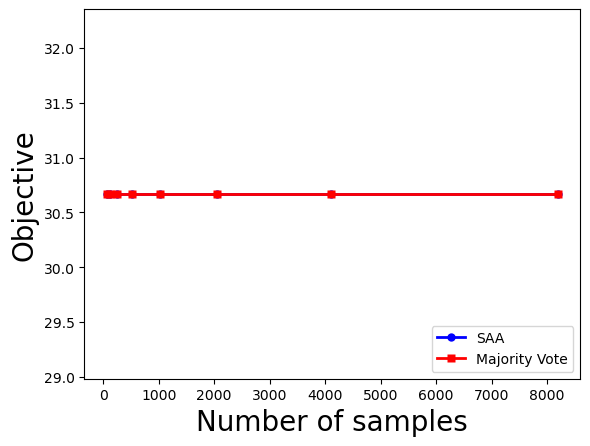

Parameters: {'C': array([0.48535827, 1.54634281]), 'Q_sp': array([[[3.52974118, 1.56873178, 2.87421197, 3.18747014],
        [4.85696496, 2.40214353, 2.98257236, 2.29810341]],

       [[2.90887478, 0.40534942, 2.78275917, 2.82223938],
        [1.91542065, 0.79436797, 3.34612623, 3.18845238]]]), 'Q_pc': array([[[1.36972352, 1.20532088, 0.80940209, 2.28128913],
        [0.38055496, 1.39262478, 2.84101765, 1.95921237],
        [3.42507953, 4.81053887, 2.14251208, 0.30973416]],

       [[3.27265753, 4.37774909, 0.87359084, 4.93018193],
        [3.02105081, 0.08407003, 2.81535668, 0.67022905],
        [4.29819571, 2.42404036, 2.72464363, 3.15072605]]]), 'R': array([[2.8199323 , 4.65170104, 2.77507475, 4.6157083 ],
       [4.90504555, 2.63785596, 2.4621298 , 1.11218017]]), 'M': array([2.75418244, 3.66001015]), 'H': array([[3.57557348, 4.8602301 , 0.05722901, 3.19107832],
       [1.87810771, 0.36256538, 4.60432388, 1.61413527],
       [3.37528508, 1.51615935, 2.98636356, 2.24341485]])}, a_ls:

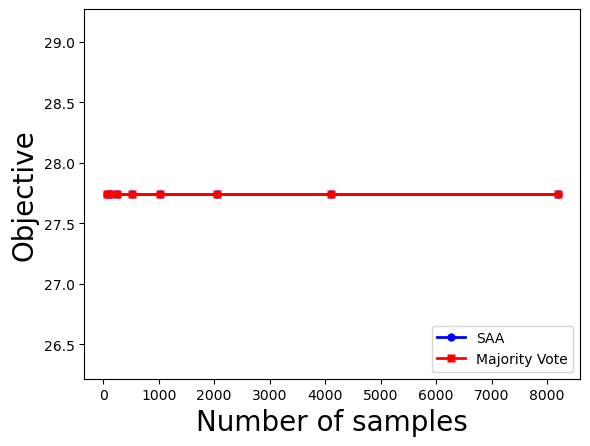

Parameters: {'C': array([4.28638449, 1.3841047 ]), 'Q_sp': array([[[1.8519102 , 4.45520983, 3.26046552, 0.48824837],
        [0.27616153, 3.99371644, 1.06077416, 1.43232556]],

       [[0.23161283, 1.01619529, 2.23408025, 0.78382139],
        [1.65267897, 3.79422893, 0.56271888, 2.85400322]]]), 'Q_pc': array([[[4.13322827, 3.54435607, 0.55795004, 0.40388093],
        [3.17075691, 3.62985509, 3.87569176, 4.97047896],
        [2.43017341, 1.86676789, 3.56750677, 2.12018367]],

       [[2.36645795, 1.97150782, 1.44061409, 2.193269  ],
        [1.89279877, 4.61594312, 1.09321022, 3.92924701],
        [0.21829728, 3.09032514, 0.60912604, 1.20529463]]]), 'R': array([[3.31729203, 2.26089118, 2.62745211, 3.68347725],
       [2.61465673, 1.12708306, 4.62260557, 3.23371109]]), 'M': array([2.96823368, 1.12614987]), 'H': array([[4.57350989, 0.04670487, 1.42838606, 4.2952324 ],
       [3.95763886, 3.71516353, 0.4932939 , 2.91061871],
       [1.57907392, 0.18490765, 2.10159549, 2.19723488]])}, a_ls:

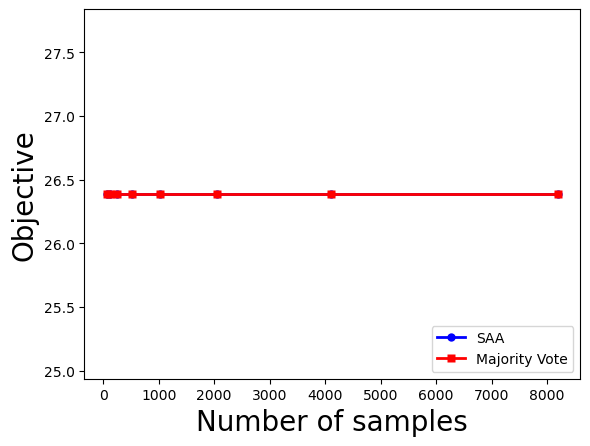

Parameters: {'C': array([0.57209878, 0.44848714]), 'Q_sp': array([[[3.6017344 , 2.57588692, 3.99877821, 1.170879  ],
        [3.95170396, 1.43866746, 3.67512069, 0.9950591 ]],

       [[3.9656546 , 1.07368233, 2.19084125, 2.37269222],
        [2.93824849, 3.4365868 , 2.76692384, 4.5157297 ]]]), 'Q_pc': array([[[2.6982743 , 1.76795026, 3.58905236, 2.19781036],
        [4.85249606, 2.02425446, 4.54526193, 4.12586444],
        [4.57393031, 0.80936524, 0.03453352, 3.42342656]],

       [[0.86695666, 1.45339971, 3.76888815, 2.27367976],
        [4.84773812, 0.47034204, 0.04126607, 0.21823842],
        [0.50373911, 2.82330996, 4.89840335, 3.99969428]]]), 'R': array([[4.15534123, 2.96804442, 4.3565974 , 3.40855166],
       [3.14134117, 3.570091  , 4.6101153 , 2.76327056]]), 'M': array([3.86893883, 2.85943294]), 'H': array([[0.33398459, 0.43559321, 0.80593008, 3.19922136],
       [3.59368301, 2.66902663, 0.35500802, 3.44262735],
       [4.3517604 , 2.80676212, 0.14005937, 2.49447953]])}, a_ls:

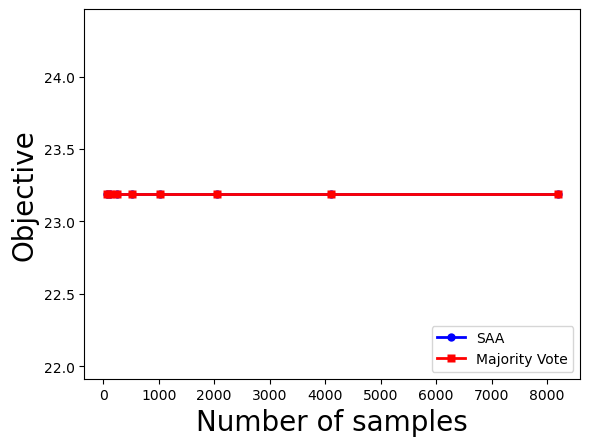

Parameters: {'C': array([2.90258264, 2.33694604]), 'Q_sp': array([[[2.69264645, 0.7365538 , 3.64604244, 4.58186361],
        [2.7224284 , 0.55263677, 1.08908133, 4.73081047]],

       [[4.32868732, 0.23156119, 0.64553613, 0.05604599],
        [0.7362285 , 3.23433959, 0.63549414, 1.08032751]]]), 'Q_pc': array([[[3.06088239, 3.86385581, 3.15219483, 3.67878921],
        [0.24154972, 1.29852317, 3.52130652, 3.66469252],
        [3.06588155, 1.84693455, 4.66600778, 2.61764965]],

       [[2.75888281, 3.47223009, 4.95468609, 2.64008985],
        [4.38455003, 0.56440318, 0.29312263, 4.41831615],
        [3.87346681, 0.76600665, 1.53471493, 1.34505186]]]), 'R': array([[1.77887025, 4.86808531, 4.63318832, 4.18264896],
       [0.6940727 , 0.47832586, 3.72126227, 4.02683256]]), 'M': array([4.91372312, 0.61507246]), 'H': array([[2.8844892 , 3.68982649, 4.53355766, 4.20868018],
       [1.21473316, 2.57949684, 0.80764604, 1.5984435 ],
       [3.89439565, 4.21269019, 3.71998718, 3.33132573]])}, a_ls:

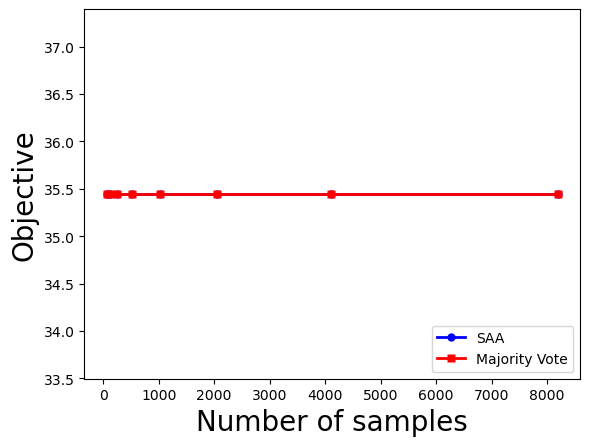

Parameters: {'C': array([0.21996075, 2.30098795]), 'Q_sp': array([[[0.55461893, 2.96214052, 3.34635727, 2.38346724],
        [4.85355478, 1.57481181, 2.74406344, 1.09047486]],

       [[1.35884665, 3.67408957, 2.40286968, 4.02514908],
        [3.31190491, 2.15736725, 1.63442892, 1.36572956]]]), 'Q_pc': array([[[3.6663873 , 4.904515  , 0.87505723, 1.82383722],
        [2.61473575, 1.54625166, 1.33597154, 0.28502309],
        [1.2411081 , 2.95958623, 3.96658576, 0.5041877 ]],

       [[3.54129075, 3.03318979, 4.42823581, 4.60703168],
        [1.01915255, 2.65095008, 4.60348207, 3.26891024],
        [1.93064371, 4.5937948 , 1.02085513, 0.31474514]]]), 'R': array([[2.19672147, 2.65369254, 4.28449204, 2.97673897],
       [1.38445915, 4.89236471, 1.24435083, 4.82662763]]), 'M': array([4.29927536, 2.24334122]), 'H': array([[3.99221929, 1.25700169, 0.67525332, 1.69658758],
       [3.31838601, 3.85447314, 1.69529205, 1.42361936],
       [4.7083406 , 2.39252208, 2.03745483, 4.46397996]])}, a_ls:

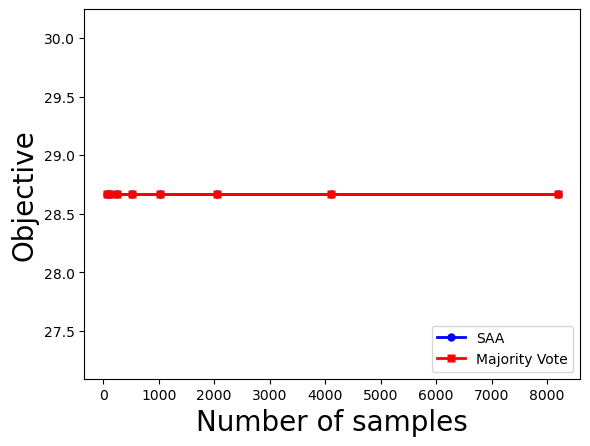

Parameters: {'C': array([1.98232598, 2.01402357]), 'Q_sp': array([[[0.64003444, 0.64193735, 3.43868365, 0.70957614],
        [4.04499617, 4.88136207, 0.12268689, 0.6166028 ]],

       [[2.01093931, 4.0692354 , 3.8749107 , 1.28804889],
        [0.31990626, 0.84449817, 1.45703141, 1.74405825]]]), 'Q_pc': array([[[1.67132837, 2.11684007, 0.56159524, 0.35688586],
        [1.37731783, 3.94055003, 2.54014768, 2.69553887],
        [1.76768459, 2.90830372, 2.49529837, 2.34008679]],

       [[0.84158011, 1.33701273, 1.11373659, 1.96435973],
        [4.39820982, 2.68395742, 4.74023415, 0.05861399],
        [4.95524038, 3.5935569 , 0.51629461, 3.32045147]]]), 'R': array([[2.05921123, 2.88665016, 3.69240913, 3.90448916],
       [4.09886715, 4.29124882, 3.15480741, 1.2502039 ]]), 'M': array([4.58771642, 3.72244055]), 'H': array([[2.89831521, 0.14973731, 4.60345142, 1.8782913 ],
       [4.95733807, 1.09690577, 3.06508419, 0.63251696],
       [4.85646776, 3.13382952, 4.71273488, 0.60511338]])}, a_ls:

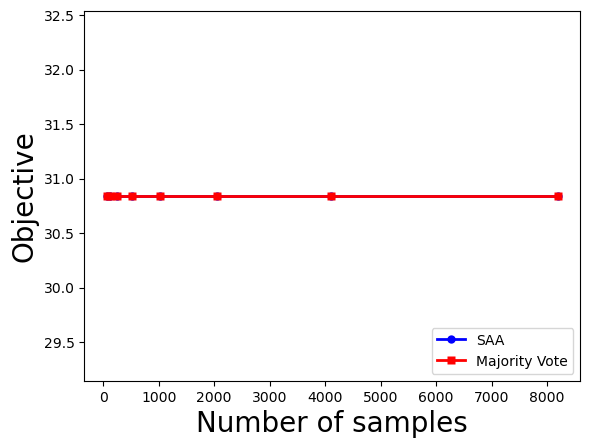

Parameters: {'C': array([3.51195129, 3.6837729 ]), 'Q_sp': array([[[0.48439057, 1.09159387, 2.53225559, 4.8704857 ],
        [0.36865354, 3.95338893, 2.18166608, 2.75328068]],

       [[0.95427034, 2.29935241, 1.15166147, 3.33853622],
        [0.33732075, 4.89151852, 3.30138306, 1.36022847]]]), 'Q_pc': array([[[3.55290589e+00, 2.46985802e+00, 3.08618617e-01, 4.64115978e+00],
        [6.51006952e-01, 2.57067086e+00, 1.87998496e+00, 4.73014923e+00],
        [2.18071306e+00, 4.41980640e+00, 1.85148544e+00, 3.42404508e+00]],

       [[2.35970091e+00, 1.08429436e-02, 1.82702220e+00, 4.56603371e+00],
        [1.40192069e-03, 3.14073965e-01, 3.05589015e+00, 1.56248349e+00],
        [3.34482638e+00, 4.75068741e+00, 4.83945031e+00, 1.88653699e+00]]]), 'R': array([[2.77706377, 1.37097085, 2.69031549, 1.60787715],
       [4.6909688 , 2.9633337 , 4.93462907, 2.05455825]]), 'M': array([1.28428533, 2.24900166]), 'H': array([[2.54821678, 3.56541112, 0.68985678, 2.48679793],
       [4.55590806, 1.0278

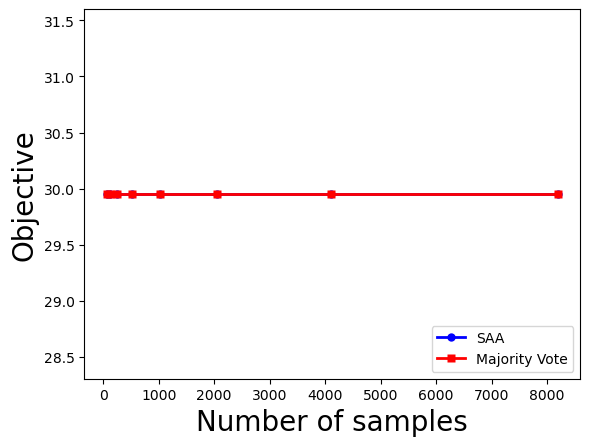

Parameters: {'C': array([0.08239482, 1.9321381 ]), 'Q_sp': array([[[3.82825812, 1.47626378, 3.51688939, 3.1573017 ],
        [0.42826589, 0.77178242, 0.30677448, 4.97309389]],

       [[0.26811224, 1.9748874 , 3.78118256, 1.61476132],
        [1.34072047, 1.39192281, 0.39509233, 2.70720695]]]), 'Q_pc': array([[[3.56722845, 0.05028195, 2.90148051, 4.3112058 ],
        [3.9706547 , 0.16889723, 0.35871674, 4.70504175],
        [3.12233644, 2.88462718, 4.1310396 , 0.23442374]],

       [[3.60751122, 1.14639164, 2.3853354 , 0.67740632],
        [2.10721184, 1.46069029, 2.00526998, 1.79087961],
        [1.57603461, 2.63545338, 3.54058079, 0.11848723]]]), 'R': array([[2.07443591, 4.80010353, 0.37077522, 0.15701887],
       [4.18209212, 2.16197826, 3.90409901, 4.84915792]]), 'M': array([0.57037262, 2.2680751 ]), 'H': array([[3.57191763, 1.46986655, 0.12955823, 2.44008779],
       [4.63979215, 1.3729308 , 3.70426633, 2.55798036],
       [2.20331126, 0.02162618, 4.86128713, 2.96885619]])}, a_ls:

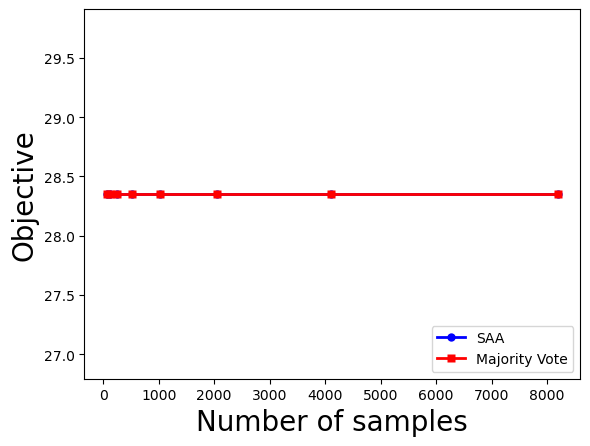

Parameters: {'C': array([2.91901727, 0.93480781]), 'Q_sp': array([[[1.96725098, 0.49237323, 3.30978881, 2.60670114],
        [2.59857131, 0.53576064, 1.84984883, 0.97486993]],

       [[4.64620264, 0.64957048, 4.68166925, 0.74291745],
        [0.82482067, 0.63003494, 3.41936877, 4.30293806]]]), 'Q_pc': array([[[1.93090837, 4.97211638, 3.71481358, 3.61850273],
        [4.10080664, 2.73796806, 2.35248288, 1.43758114],
        [4.27630074, 0.08804886, 3.16031926, 0.17906324]],

       [[0.66909687, 0.11010038, 3.80998526, 2.92813409],
        [3.87083186, 4.08653107, 1.39598724, 4.73415564],
        [2.21282364, 2.92641632, 0.88420562, 0.25975106]]]), 'R': array([[1.77734906, 2.40797224, 1.65847219, 3.52426065],
       [4.62643496, 3.17280859, 1.18101764, 2.77992988]]), 'M': array([1.52663404, 0.88164431]), 'H': array([[3.1817187 , 3.3190974 , 2.72328684, 3.79357322],
       [3.92870121, 0.72505891, 3.652058  , 0.14141875],
       [0.43148181, 2.96867423, 1.82050788, 3.50495743]])}, a_ls:

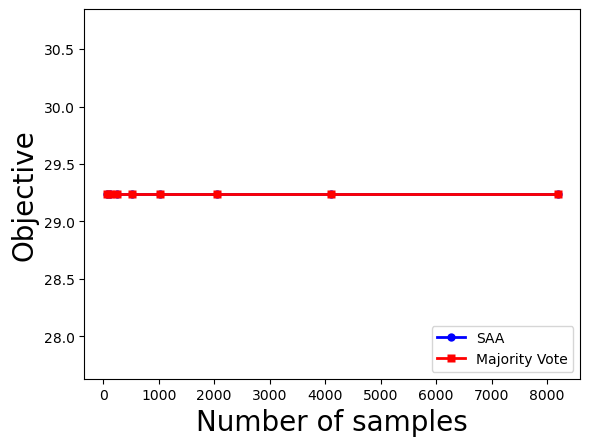

Parameters: {'C': array([4.79968507, 0.27267382]), 'Q_sp': array([[[2.99357996, 1.91658479, 4.27014782, 3.57287976],
        [4.46034765, 0.71433116, 1.95105308, 0.62548578]],

       [[0.10039153, 3.26122042, 2.92752269, 1.1294501 ],
        [3.56804654, 4.23667877, 4.12558227, 4.14973873]]]), 'Q_pc': array([[[4.43784424, 1.51941497, 2.53111099, 2.26913625],
        [0.76039487, 1.37437133, 1.94853406, 2.42667543],
        [4.56968754, 4.21943656, 2.89065659, 4.46109289]],

       [[4.43416116, 2.11560022, 3.07524736, 1.50274773],
        [1.97705435, 2.42535488, 4.87031989, 1.8644926 ],
        [1.46843072, 1.38882488, 1.96757582, 3.47441783]]]), 'R': array([[2.3167249 , 0.68017458, 3.61117945, 3.38750072],
       [0.70462435, 0.81671083, 1.46281246, 3.5797841 ]]), 'M': array([3.17983891, 4.65426017]), 'H': array([[4.82855236, 3.96967785, 2.50657972, 2.73166384],
       [2.55534662, 1.96383253, 2.0956021 , 4.50128135],
       [1.39359126, 0.19910206, 1.67734082, 4.04315718]])}, a_ls:

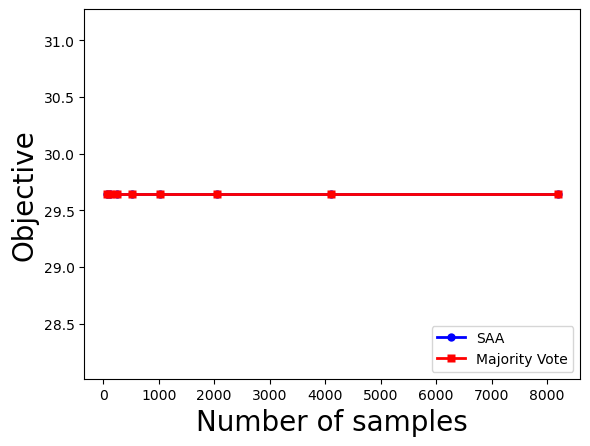

Parameters: {'C': array([2.3430815, 0.1937816]), 'Q_sp': array([[[4.93152558, 1.95614525, 1.81804204, 3.53422834],
        [0.07331269, 4.00771132, 4.52918232, 1.76092418]],

       [[0.49179242, 4.25460866, 2.34881403, 0.9571476 ],
        [0.04629947, 2.44612709, 2.32171319, 1.21138026]]]), 'Q_pc': array([[[2.23111156, 1.40174785, 1.6058132 , 3.40810394],
        [1.79353868, 4.49420896, 3.53246233, 2.44267683],
        [0.49222481, 3.96762484, 3.20224431, 2.0420451 ]],

       [[0.87379744, 0.73551538, 0.07006897, 3.73977059],
        [4.06258347, 4.38539562, 1.2895755 , 1.48485256],
        [2.02021594, 3.95247657, 1.1669837 , 1.92914618]]]), 'R': array([[2.75925776, 3.17698   , 4.40705782, 0.72388859],
       [2.66489273, 4.05741909, 2.70428079, 0.87108095]]), 'M': array([4.02530273, 2.38230804]), 'H': array([[2.81001565, 2.09007816, 1.35904674, 1.97952396],
       [4.54839329, 0.18367275, 3.64644795, 1.37331692],
       [4.05042138, 0.77629762, 3.11635571, 0.75001761]])}, a_ls: [

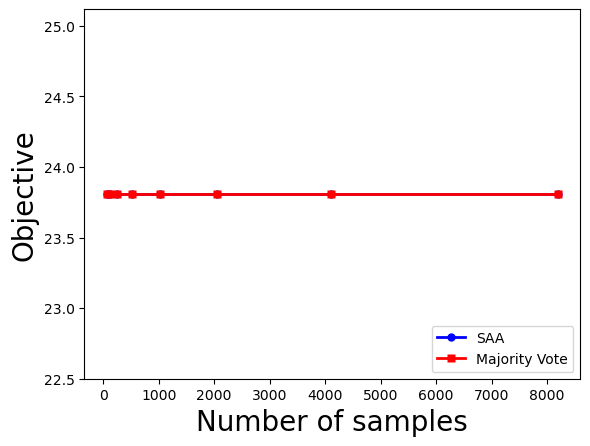

Parameters: {'C': array([4.419164  , 0.08519842]), 'Q_sp': array([[[1.45243989, 4.30589107, 0.16516608, 1.71385254],
        [2.78189473, 2.27696859, 2.14004662, 0.2515857 ]],

       [[4.82156722, 2.43010881, 0.72276357, 3.05143786],
        [0.07487871, 1.31830716, 3.31628154, 4.06225585]]]), 'Q_pc': array([[[2.46942432, 3.28970713, 4.64168156, 3.6648666 ],
        [4.65894691, 0.87836664, 0.43130927, 2.01962954],
        [3.55576253, 1.28932102, 2.65044003, 1.51632154]],

       [[3.00043888, 3.06807921, 0.07341923, 0.77909583],
        [2.79711889, 4.36988882, 0.51318926, 3.60351697],
        [2.78437716, 2.916928  , 4.3409012 , 4.83277375]]]), 'R': array([[4.09642808, 0.70587706, 3.97774571, 1.24481377],
       [3.63228785, 0.48406089, 1.69024379, 4.85417194]]), 'M': array([0.43002005, 3.8193684 ]), 'H': array([[2.92526787, 3.13695814, 3.11521072, 2.97933823],
       [0.72016758, 1.93681569, 4.63311065, 3.29685741],
       [4.83014892, 3.18815234, 4.0406881 , 2.42502019]])}, a_ls:

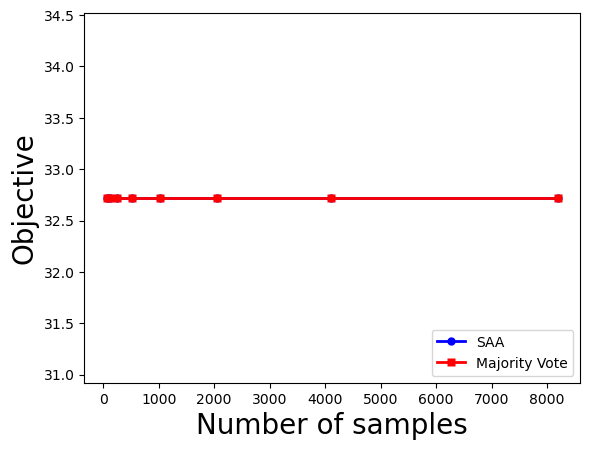

Parameters: {'C': array([0.39613492, 0.74770824]), 'Q_sp': array([[[2.30439049, 2.62460865, 0.2835382 , 0.1238188 ],
        [4.18852586, 0.51174275, 1.75923537, 3.17289866]],

       [[4.92389974, 0.57481122, 2.06282256, 1.04242662],
        [3.66219089, 3.547675  , 1.12216462, 1.21493017]]]), 'Q_pc': array([[[0.18499545, 2.03771048, 4.43557766, 2.64737125],
        [0.34462622, 1.00090394, 1.18896608, 2.41416428],
        [1.07231015, 4.64263741, 3.46940137, 2.96266863]],

       [[0.31721594, 2.58219842, 4.13570348, 0.88853839],
        [0.74937831, 3.6434884 , 0.7217858 , 3.50780785],
        [0.61883402, 4.49758796, 2.24039226, 4.99071117]]]), 'R': array([[0.35005985, 1.90571543, 0.08873858, 0.02462774],
       [4.00302051, 2.6214411 , 3.01358556, 4.10421724]]), 'M': array([3.94802275, 1.7860127 ]), 'H': array([[3.27385037, 3.29599186, 3.69260365, 1.04987507],
       [3.90325333, 2.28749126, 2.27789753, 2.81257316],
       [2.28456503, 2.38285662, 3.56252549, 3.82904968]])}, a_ls:

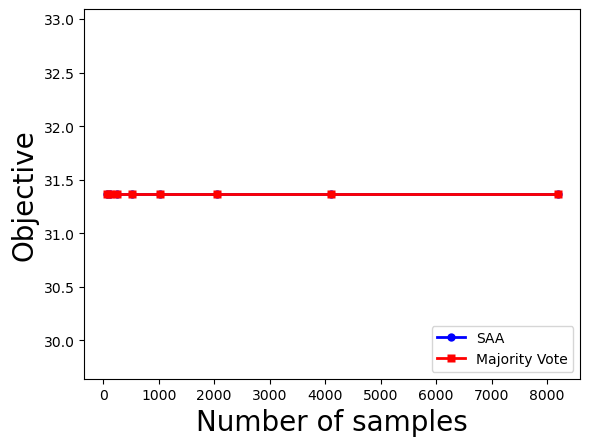

Parameters: {'C': array([2.21431366, 1.66453135]), 'Q_sp': array([[[3.50911346, 1.1361313 , 2.18505769, 4.60798213],
        [4.11402742, 4.03775436, 1.97617954, 0.78311247]],

       [[1.89253871, 3.38862385, 1.90273711, 0.29609629],
        [0.66637765, 2.3757788 , 1.83430764, 1.05477235]]]), 'Q_pc': array([[[0.48250422, 0.55303168, 4.81529754, 3.75590345],
        [1.50212075, 2.5746575 , 4.19505918, 4.89345259],
        [1.33323911, 2.16971786, 0.44426521, 3.50033679]],

       [[1.42995895, 4.10898852, 2.87927449, 4.83566858],
        [3.08793298, 1.07581007, 0.84844389, 4.49827693],
        [1.53223194, 4.12020477, 4.83538332, 4.83953455]]]), 'R': array([[3.92482488, 2.00784523, 2.39028275, 2.49607999],
       [2.90478139, 2.42613796, 4.80389311, 4.11462597]]), 'M': array([0.53379522, 0.84380406]), 'H': array([[1.02667469, 0.65662336, 3.93520331, 1.19412932],
       [2.63075388, 0.0160559 , 4.48370033, 4.23837031],
       [4.56181113, 4.54499685, 4.46501844, 0.80649967]])}, a_ls:

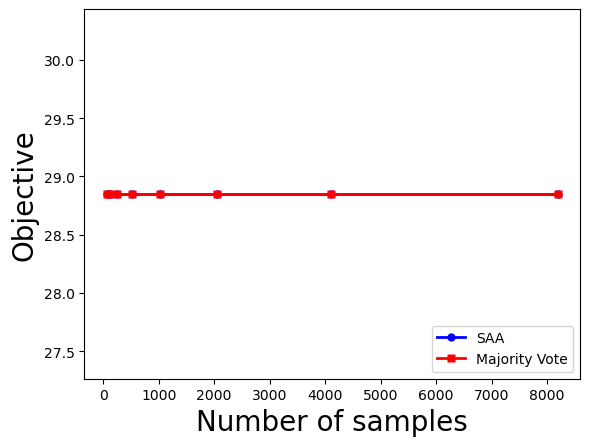

Parameters: {'C': array([4.96291607, 2.99586647]), 'Q_sp': array([[[3.98500878, 0.339167  , 0.41859901, 4.17814691],
        [1.40823137, 2.6496974 , 3.37748997, 4.31860723]],

       [[3.42867996, 4.01727142, 0.36503316, 1.66847518],
        [1.18977352, 1.25027826, 3.70194057, 4.42429264]]]), 'Q_pc': array([[[3.56125484, 1.42022444, 3.75370344, 4.39700038],
        [3.14678973, 1.85431258, 0.68369661, 4.82972976],
        [4.1570536 , 3.87930064, 4.50358976, 3.34329195]],

       [[4.91190739, 3.42546977, 3.42816861, 3.4858931 ],
        [0.84178188, 0.63616171, 4.5376719 , 0.90563682],
        [0.17449786, 4.6652037 , 3.17266599, 1.43945045]]]), 'R': array([[4.79058619, 0.50817126, 1.87613144, 3.47634037],
       [1.85717289, 0.68594953, 3.30072373, 3.8427595 ]]), 'M': array([3.46321283, 0.71189367]), 'H': array([[4.60877873, 4.70122643, 0.0057124 , 2.66278167],
       [3.8704291 , 4.89475335, 3.21338472, 3.30882963],
       [1.42263878, 1.89382058, 0.46844949, 3.72566145]])}, a_ls:

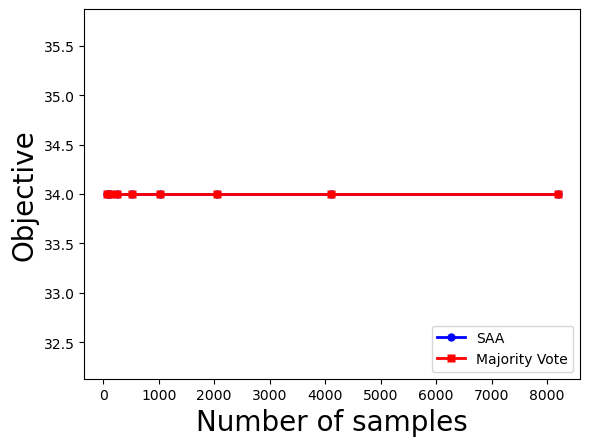

Parameters: {'C': array([3.3700399 , 0.82220626]), 'Q_sp': array([[[2.52030276, 2.73779213, 3.12750368, 0.57073966],
        [2.86718451, 1.26006952, 2.63232119, 4.2785812 ]],

       [[4.11839153, 2.78645178, 1.11379815, 4.38224276],
        [1.44860311, 2.98024744, 2.6668562 , 2.96969643]]]), 'Q_pc': array([[[0.76282456, 1.90431935, 3.11111593, 4.03935948],
        [4.59464435, 0.21819448, 3.70080797, 0.32284705],
        [0.59844115, 3.43699909, 0.20732488, 3.50298942]],

       [[1.69818546, 0.59127909, 0.94683278, 2.04384136],
        [2.76058503, 0.1359336 , 3.80203354, 0.88480586],
        [2.264616  , 4.52784694, 1.29407153, 3.6142659 ]]]), 'R': array([[1.51045932, 2.41084712, 1.99202786, 3.30161699],
       [0.19920044, 4.89288748, 4.67878262, 4.25890291]]), 'M': array([1.05885235, 3.41364731]), 'H': array([[2.25315638, 3.71787138, 3.20725218, 0.43145238],
       [4.25868158, 1.00446196, 3.4675392 , 3.45500773],
       [1.30993015, 2.81699281, 1.0690647 , 3.84453833]])}, a_ls:

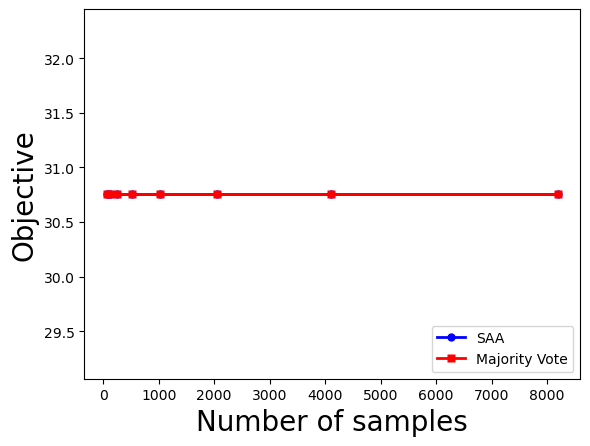

In [34]:
for result in results_list:
    print(f"Parameters: {result['parameters']}, a_ls: {result['a_ls']}")
    figure_plot(result['SAA_obj_list'], result['majority_obj_list'], sample_number)